/tmp/ipykernel_168809/2431703066.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


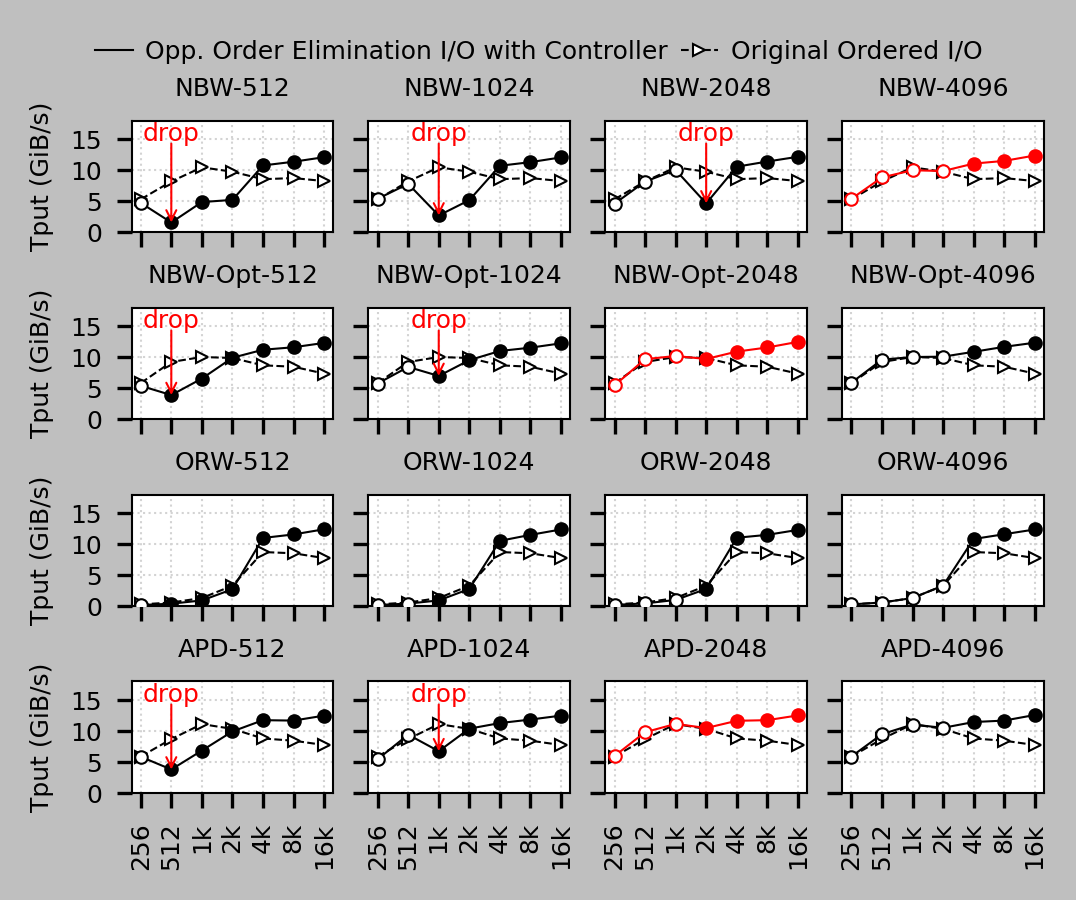

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8  # cm
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH

# Convert cm to inch for figure sizing
def cm_to_inch(value):
    return value / 2.54

# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(7)))

# Read performance data
df = pd.read_csv(
    "./performance-comparison-table", delim_whitespace=True,
    names=['fs', 'ops', 'filesz', 'blksz', 'numjobs', 'bandwidth(MiB/s)'],
    skiprows=1
)

# Extract components
# threshold = last part of fs (e.g., 'parfs-12-256' -> 256)
# prefix = fs string without the last two segments (e.g., 'parfs-12-256' -> 'parfs')
df['parts'] = df['fs'].str.split('-')
df['threshold'] = df['parts'].str[-1].astype(int)
df['prefix'] = df['parts'].str[:-2].str.join('-')
# Convert bandwidth to GiB/s
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024
line_patterns = ["-"]

# Compute mean bandwidth for each prefix, threshold, operation, block size
df_avg = (
    df.groupby(['prefix', 'threshold', 'ops', 'blksz'])['bandwidth']
      .mean()
      .reset_index()
)

line_width = 0.5
marks = ['o', 's', '^', 'D', 'x', '>', '<', 'p', '*', 'h', 'v', '1', '2', '3', '4']

# Plot configurations: (prefix, operation, title)
configs = [
    {"prefix": "append_csum_whole_block", "op": "write", "title": "NBW-", "highlight": 4096, "non-profitable": [512, 1024, 2048]},
    {"prefix": "append_csum_partial_block", "op": "write", "title": "NBW-Opt-", "highlight": 2048, "non-profitable": [512, 1024]},
    {"prefix": "parfs", "op": "randwrite", "title": "ORW-", "highlight": "","non-profitable": ""},
    {"prefix": "append_no_csum", "op": "write", "title": "APD-", "highlight": 2048, "non-profitable": [512, 1024]},
]

handles = []
labels = []
for i, cfg in enumerate(configs):
    # Filter data for this panel
    df_cfg = df_avg[(df_avg['prefix'] == cfg['prefix']) & (df_avg['ops'] == cfg['op'])]
    thresholds = sorted(df_cfg['threshold'].unique())
    thresholds.remove(256)
    thresholds.remove(32768)
    for idx, th in enumerate(thresholds):
        fid = i * 4 + idx + 1
        ax = plt.subplot(4, 4, i * 4 + idx + 1)
        df_th = df_cfg[df_cfg['threshold'] == th].sort_values('blksz')
        df_th_no_opt = df_cfg[df_cfg['threshold'] == 32768].sort_values('blksz')
        marker = marks[idx % len(marks)]
        
        # Only label in first subplot for legend\        label = f'Thr={th}' if i == 0 else None
        if cfg['highlight'] and th == cfg['highlight']:
            color = 'red'
        else:
            color = 'black'
            
        line_opt, = ax.plot(
            df_th_no_opt['blksz'], df_th_no_opt['bandwidth'],
            color="black", marker='>',
            markerfacecolor="white", markeredgecolor="black",
            markersize=3, markeredgewidth=0.5,
            linewidth=line_width,
            linestyle="--",
        )
        
        line, = ax.plot(
            df_th['blksz'], df_th['bandwidth'],
            color=color,
            linewidth=line_width,
            linestyle=line_patterns[idx % len(line_patterns)],
        )

        dele_blks = df_th[df_th['blksz'] < th]
        dele_band = dele_blks['bandwidth']
        plt.scatter(dele_blks['blksz'], dele_band, color="white", marker='o', linewidth=0.5, s=3*3, zorder=10, edgecolor=color)
        
        dele_blks = df_th[df_th['blksz'] >= th]
        dele_band = dele_blks['bandwidth']
        plt.scatter(dele_blks['blksz'], dele_band, color=color, marker='o', linewidth=0.5, s=3*3, zorder=10)
        
        if cfg['non-profitable'] != "":
            if idx < len(cfg['non-profitable']):
                non_profitable_point = cfg['non-profitable'][idx]
                plt.annotate(
                    f"drop",
                    xy=(non_profitable_point, dele_band.iloc[0]),
                    xytext=(non_profitable_point, 14),
                    fontsize=6,
                    color="red",
                    ha='center',
                    va='bottom',
                    arrowprops=dict(arrowstyle='->', color="red", lw=0.5, shrinkA=0, shrinkB=0), bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'),
                    zorder=11
                )
        
        
        if i == 2:
            handles.append(line)
            labels.append(f'Opp. Order Elimination I/O with Controller')
            handles.append(line_opt)
            labels.append(f'Original Ordered I/O')
        # Axis settings
        ax.set_xscale('log')
        ax.set_xticks([256, 512, 1024, 2048, 4096, 8192, 16384])
        if fid >= 13:
            ax.set_xticklabels(['256', '512', '1k', '2k', '4k', '8k', '16k'], fontsize=6, rotation=90)
        else:
            ax.set_xticklabels([], fontsize=6)
        # clear minor ticks
        ax.xaxis.set_minor_locator(plt.NullLocator())
        # ax.set_xlabel("Block size (B)", fontsize=6)
        
        ax.set_title(cfg['title'] + str(th), fontsize=6)
        ax.set_ylim(0, 18)
        ax.set_yticks([0, 5, 10, 15])
        if fid % 4 == 1:
            ax.set_ylabel("Tput (GiB/s)", fontsize=6)
            ax.set_yticklabels(['0', '5', '10', '15'], fontsize=6)
        else:
            ax.set_yticklabels([], fontsize=6)
        # ax.tick_params(axis='both', which='major', length=2, direction='out')
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

# Global legend
fig.legend(handles[:2], labels[:2], loc='center', bbox_to_anchor=(0.5, 1.01), ncol=4, columnspacing=0.5, handletextpad=0.5, handlelength=1.5, frameon=False, fontsize=6)

# plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.34, wspace=0.07)
plt.tight_layout(pad=0.4)
plt.savefig("./FIO-IO-THRESHOLD.pdf", bbox_inches='tight', pad_inches=0.05)
